In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import iplot

---
### Sub：Metrics

In [3]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [4]:
def showPlot(true, prediction, model , test_set, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + model + ' ' + test_set + ' t' + str(t))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + model + '-' + test_set + '-' + str(t) + '.png')
    plt.show()

---
### Sub：Data

In [5]:
# 20160101~20161231 [0~366]
# 20170101~20171231 [366~731]
# 20180101~20181231 [731~1095]
# 20190101~20190930 [1096~1368]
# df = pd.read_csv('Data/elec_merge_20160101_20190930.csv')
df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.shape

(1369, 12)

In [6]:
df.head()

,Date,kW,PeakLoad(MW),isHoliday,week,week_update,dayOfYear,Temp_Taipei,PeakLoad(MW)_shift7,isHoliday_shift7,weekUpdate_shift7,Temp_Taipei_shift7
0,2016-01-01,263.799,23038,1.0,5,7,1,14.6,26400.0,0.0,5.0,12.0
1,2016-01-02,261.975,23209,1.0,6,6,2,15.7,24308.0,1.0,6.0,12.1
2,2016-01-03,266.167,23686,1.0,7,7,3,16.0,23490.0,1.0,7.0,16.2
3,2016-01-04,302.227,27518,0.0,1,1,4,17.7,27207.0,0.0,1.0,13.5
4,2016-01-05,313.328,27635,0.0,2,2,5,17.8,26747.0,0.0,2.0,11.4


In [7]:
# 資料維度擷取
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    data.shape
    return data

In [8]:
from sklearn.preprocessing import MinMaxScaler
def normalize(data):
    sc = MinMaxScaler(feature_range = (0, 1))
    data_scaled = pd.DataFrame(sc.fit_transform(data))
    return sc, data_scaled 

def deNormalize(sc, value):
    value_unscaled = value * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    return value_unscaled 

In [9]:
# 僅負責滾動資料
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)  
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print('X_train.shape, Y_train.shape', X_train.shape, Y_train.shape)
    return X_train, Y_train

In [10]:
# 僅負責滾動資料
def buildTest(test, pastDay=7, futureDay=7):
    X_test = []
    for i in range(0, int(len(test)/futureDay)-(pastDay-futureDay)):
        X_test.append(test[futureDay*i:futureDay*i+pastDay])
    X_test = np.array(X_test)
    print('buildTest.shape', X_test.shape)
#     print('buildTest', X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  
    print('buildTest.shape', X_test.shape)
    return X_test

In [11]:
# 拆分訓練與驗證，需要手動切割時才使用
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [12]:
def forecast(model, input_data, shape):
    forecast_temp = model.predict(input_data)
    # Append Data
    forecast = []
    for i in range(forecast_temp.shape[0]):
        forecast= np.concatenate((forecast, forecast_temp[i]), axis=0)
    # Reshape
    forecast = np.reshape(forecast, (shape[0], shape[1]))
    print('Truth.shape, Forecast.shape', shape, forecast.shape)
    return forecast

---
### Sub：Model

In [13]:
# 關閉警告
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


In [14]:
def buildModel(shape, train_x, train_y):
    epochs, batch_size = 1000, 50
    # batch_size = 16
    # epochs = 200
    model = Sequential()
    model.add(SimpleRNN(units = 200, activation='relu', input_shape = (shape[1], shape[2])))
    model.add(RepeatVector(7))
    model.add(SimpleRNN(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    #     model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(units = 7))
    model.compile(loss='mse', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=15, mode='min', verbose=0)
    earlyStop=EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True)
    modelResult = model.fit(train_x, train_y, 
                            epochs=epochs, batch_size=batch_size, 
                            verbose=0, 
                            validation_split=0.1, 
#                             shuffle=False,
                            callbacks=[reduce_lr, earlyStop])
    return model, modelResult

In [17]:
def evaluate_model(model, sc, SelfTruth, S_test, RawTrurh, X_test):
    self_predict = forecast(model, S_test, self_trurh.shape)
    self_predict = deNormalize(sc, self_predict)
    test_predict = forecast(model, X_test, test_trurh.shape)
    test_predict = deNormalize(sc, test_predict)
    return self_predict, test_predict

---
### Main

In [15]:
features = [
            'kW', 
            'PeakLoad(MW)_shift7', 
            'isHoliday_shift7', 
            'dayOfYear', 
            'weekUpdate_shift7', 
            'Temp_Taipei_shift7'
           ]

In [16]:
trainFrom = '2017-01-04'
trainTo = '2019-01-01'
testFrom = '2019-01-02'
testTo = '2019-09-24'

In [17]:
# 特徵選取
RawData = augFeatures(df, features)
# 正規化
sc, RawData = normalize(RawData)

In [44]:
# 根據給定的時間範圍自動產生訓練、測試資料集
def split_dataset(data, pastDay=7, futureDay=7):
    num_train_start = df[df['Date'] == trainFrom].index.item()
    num_train_end = df[df['Date'] == trainTo].index.item() + 1
    num_test_start = df[df['Date'] == testFrom].index.item()
    num_test_end = df[df['Date'] == testTo].index.item() + 1
    print("num_train_start", num_train_start)
    print("num_train_end", num_train_end)
    print("num_test_start", num_test_start)
    print("num_test_end", num_test_end)
    if((num_test_end - num_test_start) % futureDay):
        print("．Data range error.")
    test_react = (num_test_end - num_test_start + 1 ) % futureDay
    print('．test_react', test_react)
    self_react = (num_test_end - num_train_start + 1) % futureDay
    print('．self_react', self_react)

    # 訓練資料
    RawTrain = data[num_train_start : num_train_end]
    # 自我測試集
    SelfTest = data[num_train_start : num_test_end - futureDay]
    SelfTruth = data[num_train_start + pastDay : num_test_end - self_react][0]
    # 實際預測集
    RawTest = data[num_test_end - pastDay : num_test_end - futureDay]
    RawTrurh = data[num_test_end : num_test_end - test_react][0]

    print("RawTrain", RawTrain.shape)
    print("SelfTest, SelfTruth", SelfTest.shape, SelfTruth.shape)
    print("RawTest, RawTrurh", RawTest.shape, RawTrurh.shape)
    return RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth

In [45]:
# 自定義變數
Timesteps = 7
OutputDay = 6

# 資料選取
RawTrain, RawTest, RawTrurh, SelfTest, SelfTruth  = split_dataset(RawData, Timesteps, OutputDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, Timesteps, OutputDay)
S_test = buildTest(SelfTest.values, Timesteps, OutputDay)
X_test = buildTest(RawTest.values, Timesteps, OutputDay)

# 驗證資料
# X, Y, Xv, Yv= splitData(X_train, Y_train, 0.1)

num_train_start 369
num_train_end 1097
num_test_start 1097
num_test_end 1363
．Data range error.
．test_react 3
．self_react 5
RawTrain (728, 6)
SelfTest, SelfTruth (988, 6) (982,)
RawTest, RawTrurh (1, 6) (0,)
X_train.shape, Y_train.shape (715, 7, 6) (715, 6)
buildTest.shape (163, 7, 6)
buildTest.shape (163, 7, 6)
buildTest.shape (0,)


IndexError: tuple index out of range

In [34]:
%%time
total_self = []
total_test = []
for i in range(10):
    print(i)
    model, modelResult = buildModel(X_train.shape, X_train, Y_train)
    self_predict, test_predict = evaluate_model(model, sc, SelfTruth, S_test, RawTrurh, X_test)
    total_self.append(np.reshape(self_predict, (self_predict.shape[0])))
    total_test.append(np.reshape(test_predict, (test_predict.shape[0])))
mean_self = np.array(total_self).mean(axis=0)
mean_test = np.array(total_test).mean(axis=0)
# reshape
mean_self = np.reshape(mean_self, (mean_self.shape[0], 1))
mean_test = np.reshape(mean_test, (mean_test.shape[0], 1))

0


ValueError: Error when checking target: expected dense_2 to have shape (7,) but got array with shape (5,)

---
## Time

In [530]:
t = 1
save = True
# save = False
model_name = '(XT_RNN_2017)'

---
## Load Model

In [531]:
# # load
# from keras.models import load_model
# model = load_model('Model/industryElec_cLSTM(7to7)_model_0' + str(t) + '.h5')

---
## Self-Prediction

RMSE 4.185286272435986
MAPE 0.9310366755152758


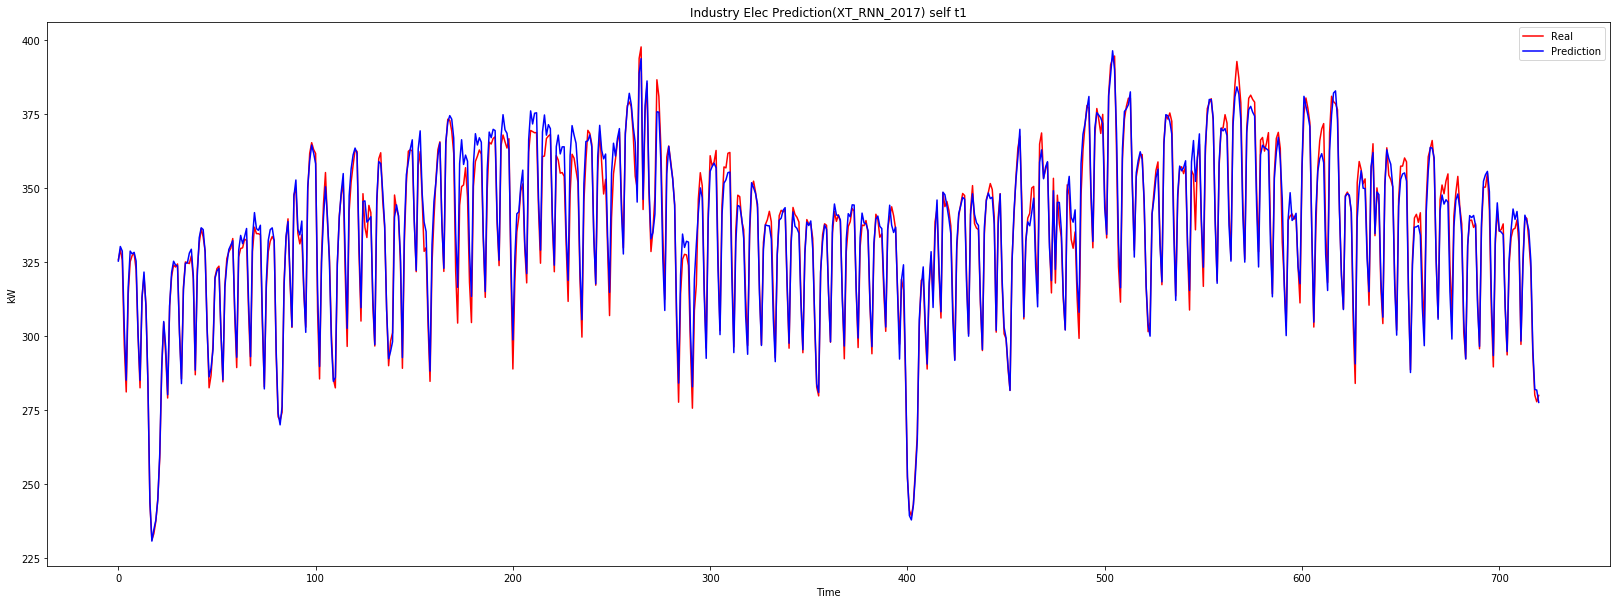

In [540]:
# 自我測試
self_trurh = pd.DataFrame(SelfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
calcError(self_trurh, mean_self)
showPlot(self_trurh, mean_self, model_name , "self", size="L", save=save)

---
## Test-Prediction

RMSE 9.516935162401442
MAPE 2.1730191342790612


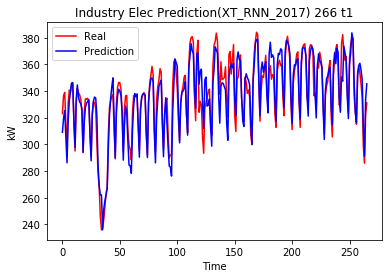

In [541]:
# 實際測試
test_trurh = pd.DataFrame(RawTrurh)
test_trurh = deNormalize(sc, test_trurh.values)
calcError(test_trurh, mean_test)
showPlot(test_trurh, mean_test, model_name , str(266), save=save)

---
## Save Model

In [ ]:
# import h5py
# Model.save('Model/industryElec_cLSTM(7to7)_model_01.h5')